# Проект курса "Временные ряды"

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Подготовка-параметров-и-разделение-выборок-для-нестационарного-временного-ряда" data-toc-modified-id="Подготовка-параметров-и-разделение-выборок-для-нестационарного-временного-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка параметров и разделение выборок для <strong>нестационарного</strong> временного ряда</a></span></li><li><span><a href="#Подготовка-параметров-и-разделение-выборок-для-стационарного-временного-ряда" data-toc-modified-id="Подготовка-параметров-и-разделение-выборок-для-стационарного-временного-ряда-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Подготовка параметров и разделение выборок для <strong>стационарного</strong> временного ряда</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#RandomForestRegressor-для-нестационарного-временного-ряда" data-toc-modified-id="RandomForestRegressor-для-нестационарного-временного-ряда-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RandomForestRegressor для <strong>нестационарного</strong> временного ряда</a></span></li><li><span><a href="#RandomForestRegressor-для-стационарного-временного-ряда" data-toc-modified-id="RandomForestRegressor-для-стационарного-временного-ряда-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor для <strong>стационарного</strong> временного ряда</a></span></li><li><span><a href="#LGBMRegressor-для-нестационарного-временного-ряда" data-toc-modified-id="LGBMRegressor-для-нестационарного-временного-ряда-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor для <strong>нестационарного</strong> временного ряда</a></span></li><li><span><a href="#LGBMRegressor-для-стационарного-временного-ряда" data-toc-modified-id="LGBMRegressor-для-стационарного-временного-ряда-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor для <strong>стационарного</strong> временного ряда</a></span></li><li><span><a href="#Лучшая-модель" data-toc-modified-id="Лучшая-модель-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Лучшая модель</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Проверим, в хронологическом ли порядке расположены даты и время:

In [4]:
df = df.sort_index() 
print(df.index.is_monotonic)

True


Выполним ресемплирование:

In [5]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

In [6]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Посмотрим на данные в разрезе дня и недели:

<AxesSubplot:xlabel='datetime'>

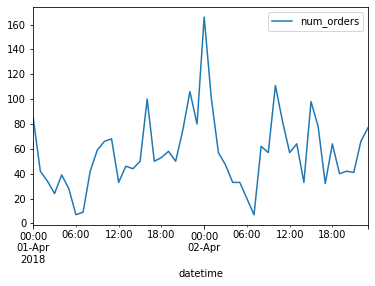

In [7]:
df_day = df['2018-04-01':'2018-04-02']
df_day.plot()

<AxesSubplot:xlabel='datetime'>

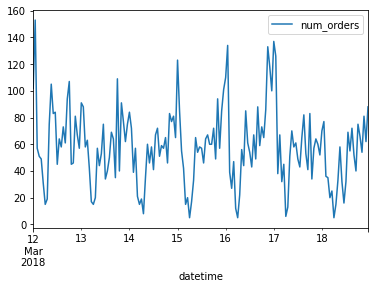

In [8]:
df_week = df['2018-03-12':'2018-03-18']
df_week.plot()

С помощью скользящего среднего и скользящего среднего отклонения посмотрим значения, которые меньше всего подвержены колебаниям

<AxesSubplot:xlabel='datetime'>

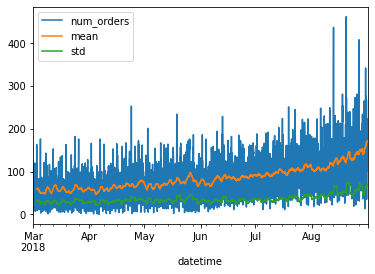

In [9]:
df['mean'] = df['num_orders'].rolling(48).mean()
df['std'] = df['num_orders'].rolling(48).std()
df.plot()

Разложим ряд на тренд, сезонность и остаток:

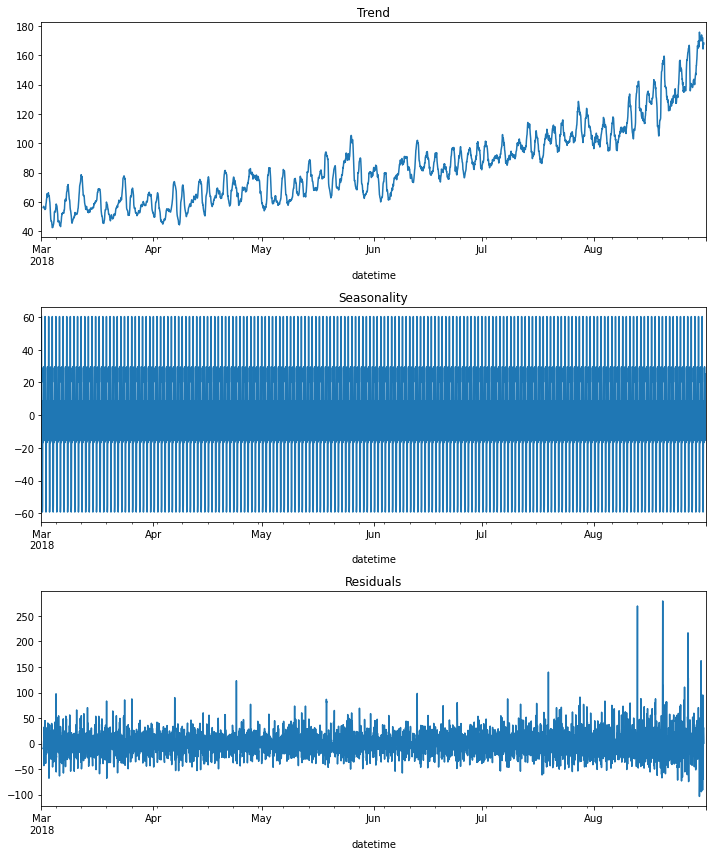

In [10]:
decomposed = seasonal_decompose(df['num_orders']) # < напишите код здесь >

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Построим график сезонной составляющей за первые 7 дней:

<AxesSubplot:xlabel='datetime'>

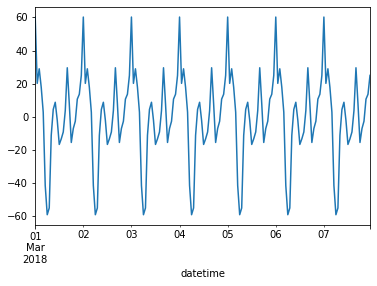

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())

Из графика Trend видно, что наш временной ряд **нестационарный**. Это может помешать нашему прогнозированию, поэтому в дальнейшем будем использовать при обучении и стационарный и нестационарный и сравним метрики.
Чтобы ряд сделать стационарным, вычислим разности временного ряда

In [12]:
df = df.drop(['mean', 'std'], axis=1)

<AxesSubplot:xlabel='datetime'>

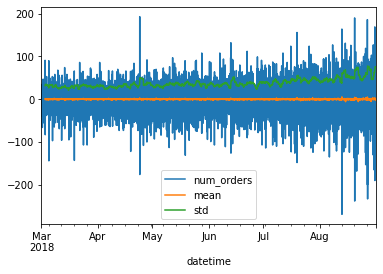

In [13]:
df_shift = df - df.shift() 
df_shift['mean'] = df_shift['num_orders'].rolling(48).mean()
df_shift['std'] = df_shift['num_orders'].rolling(48).std()
df_shift.plot()

Подготовим параметры с помощью функции. Разобьем параметры на следующие виды:
- Календарные признаки (месяц, день, день недели, час) 
- «Отстающие значения»
- Скользящее среднее

In [14]:
df_shift = df_shift.drop(['mean', 'std'], axis=1)

In [15]:
TARGET = 'num_orders'

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[TARGET].shift(lag)

    data['rolling_mean'] = data[TARGET].shift().rolling(rolling_mean_size).mean()

### Подготовка параметров и разделение выборок для **нестационарного** временного ряда

In [17]:
make_features(df, 24, 7)
df

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,167.428571
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.428571
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,165.714286


In [18]:
train, temp = train_test_split(df, test_size=0.2, shuffle=False)
valid, test = train_test_split(temp, test_size=0.5, random_state=12345)

train = train.dropna()

features_train = train.drop([TARGET], axis=1)
target_train = train[TARGET]

features_valid = valid.drop([TARGET], axis=1)
target_valid = valid[TARGET]

features_test = test.drop([TARGET], axis=1)
target_test = test[TARGET]

print('Размер выборки _train', features_train.shape)
print('Размер выборки _valid', features_valid.shape)
print('Размер выборки _test', features_test.shape)

Размер выборки _train (3508, 29)
Размер выборки _valid (442, 29)
Размер выборки _test (442, 29)


### Подготовка параметров и разделение выборок для **стационарного** временного ряда

In [19]:
make_features(df_shift, 24, 7)
df_shift

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,NaN,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-39.0,3,1,3,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14.0,3,1,3,2,-39.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5.0,3,1,3,3,-14.0,-39.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-23.0,3,1,3,4,-5.0,-14.0,-39.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-71.0,8,31,4,19,-10.0,20.0,81.0,-17.0,-33.0,...,-131.0,36.0,-82.0,30.0,88.0,-40.0,56.0,70.0,-105.0,5.714286
2018-08-31 20:00:00,18.0,8,31,4,20,-71.0,-10.0,20.0,81.0,-17.0,...,169.0,-131.0,36.0,-82.0,30.0,88.0,-40.0,56.0,70.0,0.000000
2018-08-31 21:00:00,5.0,8,31,4,21,18.0,-71.0,-10.0,20.0,81.0,...,-190.0,169.0,-131.0,36.0,-82.0,30.0,88.0,-40.0,56.0,-1.714286


In [20]:
train_shift, temp_shift = train_test_split(df_shift, test_size=0.2, shuffle=False)
valid_shift, test_shift = train_test_split(temp_shift, test_size=0.5, random_state=12345)

train_shift = train_shift.dropna()

features_train_shift = train_shift.drop([TARGET], axis=1)
target_train_shift = train_shift[TARGET]

features_valid_shift = valid_shift.drop([TARGET], axis=1)
target_valid_shift = valid_shift[TARGET]

features_test_shift = test_shift.drop([TARGET], axis=1)
target_test_shift = test_shift[TARGET]

print('Размер выборки _train', features_train_shift.shape)
print('Размер выборки _valid', features_valid_shift.shape)
print('Размер выборки _test', features_test_shift.shape)

Размер выборки _train (3507, 29)
Размер выборки _valid (442, 29)
Размер выборки _test (442, 29)


## Обучение

Чтобы использовать кроссвалидацию для подбора гиперпараметоров в качестве аргумента **cv** будем использовать специальный сплиттер TimeSeriesSplit, который не будет нарушать порядок следования данных.

In [21]:
tscv = TimeSeriesSplit(n_splits=8) #3)

Подберем гипермараметры для RandomForestRegressor и LGBMRegressor и обучим модели с использованием лучших из них

### RandomForestRegressor для **нестационарного** временного ряда

In [22]:
model = RandomForestRegressor()
params = {
    'n_estimators' : [10, 20, 30],
    'max_depth' : [3, 5, 10],
    'random_state' : [12345]
    }
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train)
rf_params = grid_cv.best_params_
rf_rmse = (-grid_cv.best_score_) ** 0.5
print('Best hyperparams: ', rf_params)
print('Train RMSE: {:.2f}'.format(rf_rmse))

Best hyperparams:  {'max_depth': 10, 'n_estimators': 30, 'random_state': 12345}
Train RMSE: 23.62


In [23]:
model_rf = RandomForestRegressor(**rf_params)
model_rf.fit(features_train, target_train)

predict_rf = model_rf.predict(features_valid)

rmse_rf = mean_squared_error(target_valid, predict_rf)**0.5

print('Valid RMSE = {:.2f}'.format(rmse_rf))

Valid RMSE = 41.28


### RandomForestRegressor для **стационарного** временного ряда

In [24]:
model = RandomForestRegressor()
params = {
    'n_estimators' : [10, 20, 30],
    'max_depth' : [3, 5, 10],
    'random_state' : [12345]
    }
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train_shift, target_train_shift)
rf_params = grid_cv.best_params_
rf_rmse = (-grid_cv.best_score_) ** 0.5
print('Best hyperparams: ', rf_params)
print('Train RMSE: {:.2f}'.format(rf_rmse))

Best hyperparams:  {'max_depth': 10, 'n_estimators': 30, 'random_state': 12345}
Train RMSE: 26.89


In [25]:
model_rf_shift = RandomForestRegressor(**rf_params)
model_rf_shift.fit(features_train_shift, target_train_shift)

predict_rf_shift = model_rf_shift.predict(features_valid_shift)

rmse_rf_shift = mean_squared_error(target_valid_shift, predict_rf_shift)**0.5

print('Valid RMSE = {:.2f}'.format(rmse_rf_shift))

Valid RMSE = 40.82


### LGBMRegressor для **нестационарного** временного ряда

In [26]:
model = LGBMRegressor()
params = {
    'boosting_type' : ['gbdt'],
    'n_estimators' : [50, 100, 200],
    'max_depth' : [5, 7, 10],
    'verbose' : [-1],
    'random_state' : [12345],
    'force_col_wise': [True],
    'num_leaves' : [30, 130, 200]
    }
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train)
lgb_params = grid_cv.best_params_
lgb_rmse = (-grid_cv.best_score_) ** 0.5
print('Best hyperparams: ', lgb_params)
print('Train RMSE: {:.2f}'.format(lgb_rmse))

Best hyperparams:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 30, 'random_state': 12345, 'verbose': -1}
Train RMSE: 23.08


In [27]:
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(features_train, target_train)

predict_lgb = model_lgb.predict(features_valid)

rmse_lgb = mean_squared_error(target_valid, predict_lgb)**0.5

print('Valid RMSE = {:.2f}'.format(rmse_lgb))

Valid RMSE = 39.85


### LGBMRegressor для **стационарного** временного ряда

In [28]:
model = LGBMRegressor()
params = {
    'boosting_type' : ['gbdt'],
    'n_estimators' : [50, 100, 200],
    'max_depth' :[7],# [5, 7, 10],
    'verbose' : [-1],
    'random_state' : [12345],
    'force_col_wise': [True],
    'num_leaves' :[30, 130, 200]
    }
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train_shift, target_train_shift)
lgb_params = grid_cv.best_params_
lgb_rmse = (-grid_cv.best_score_) ** 0.5
print('Best hyperparams: ', lgb_params)
print('Train RMSE: {:.2f}'.format(lgb_rmse))

Best hyperparams:  {'boosting_type': 'gbdt', 'force_col_wise': True, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 30, 'random_state': 12345, 'verbose': -1}
Train RMSE: 25.02


In [29]:
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(features_train_shift, target_train_shift)

predict_lgb = model_lgb.predict(features_valid_shift)

rmse_lgb = mean_squared_error(target_valid_shift, predict_lgb)**0.5

print('Valid RMSE = {:.2f}'.format(rmse_lgb))

Valid RMSE = 37.51


### Лучшая модель

**Вывод:** лучшая модель - LGBMRegressor с подобранными гиперпараметрами для стационарного временного ряда

## Тестирование

Проведем тестирование лучшей модели:

In [30]:
predict_lgb_test = model_lgb.predict(features_test_shift)
rmse_lgb_test = mean_squared_error(target_test_shift, predict_lgb_test)**0.5
rmse_lgb_test

41.8447575177758

**Вывод: нами преобразованы данные в стационарный временной ряд, созданы параметры модели с учетом количества часов в сутках (24) и выбрана лучшая модель. С учетом этого нами достигнуто RMSE на тестовой выборке в размере 41,8.**

<AxesSubplot:xlabel='datetime'>

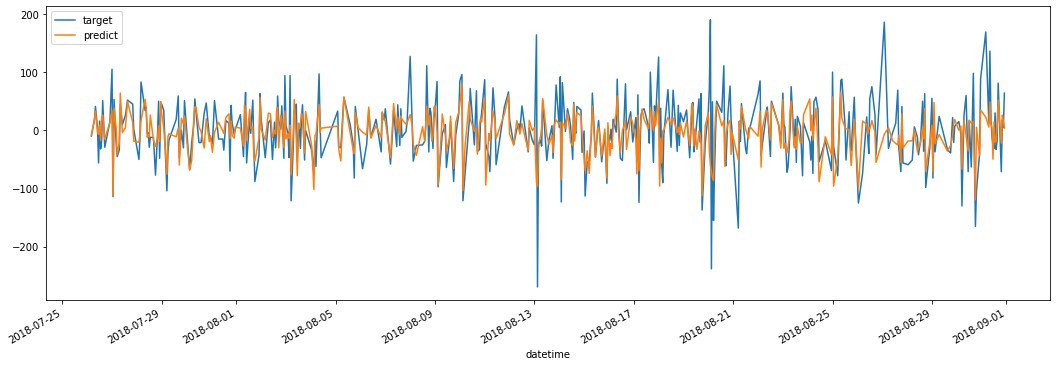

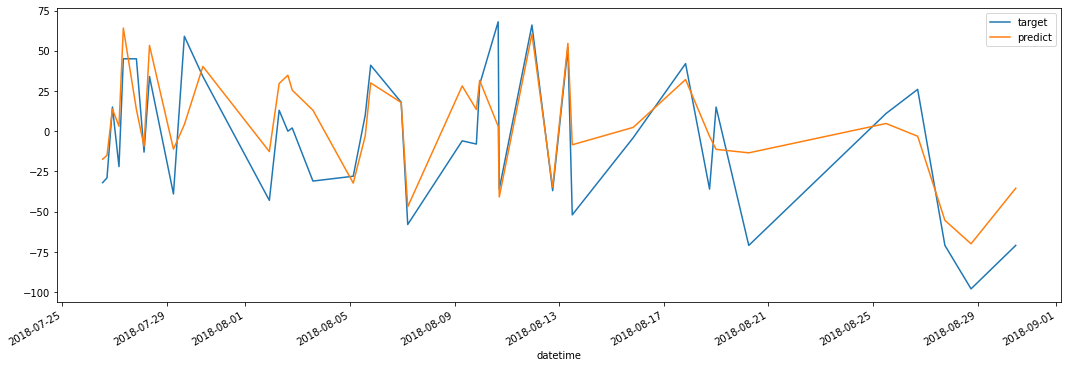

In [36]:
model_data = pd.DataFrame({"target":target_test_shift, "predict":predict_lgb_test})
model_data.plot(figsize=(18, 6))
model_data[-40:].plot(figsize=(18, 6))